In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import MatrixSymbol, Matrix, Identity
import sympy as sym
import control


# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Uso de librería "statsmodels"

Esta librería se usa mucho en aplicaciones estadísticas, pero tiene un compendio de métodos y funciones muy útiles para estimar modelos usando polinomios autorregresivos.

## Experimento de identificación

**Paso 1:** En este ejemplo cargamos datos exercise_05.csv.

,t,yn,un,y_1,y_2,u_1,u_2
2,0.2,-0.008496,2.0,0.005894,-0.006515,2.0,2.0
3,0.3,-0.004121,2.0,-0.008496,0.005894,2.0,2.0
4,0.4,0.045311,2.0,-0.004121,-0.008496,2.0,2.0
5,0.5,0.035815,2.0,0.045311,-0.004121,2.0,2.0
6,0.6,0.044628,2.0,0.035815,0.045311,2.0,2.0
...,...,...,...,...,...,...,...
66,6.6,0.603220,2.0,0.607367,0.615270,2.0,2.0
67,6.7,0.572766,2.0,0.603220,0.607367,2.0,2.0
68,6.8,0.597124,2.0,0.572766,0.603220,2.0,2.0
69,6.9,0.628013,2.0,0.597124,0.572766,2.0,2.0


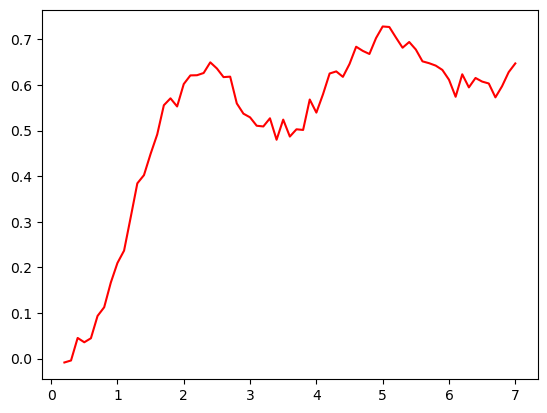

In [6]:
datos = pd.read_csv ('data\exercise_05.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un

datos['y_1'] = datos['yn'].shift(periods=1);
datos['y_2'] = datos['yn'].shift(periods=2);
datos['u_1'] = datos['un'].shift(periods=1);
datos['u_2'] = datos['un'].shift(periods=2);

datos.dropna(inplace=True);


dt = (t[1] - t[0])

plt.plot(datos.t,datos.yn,color = 'red')
datos

**Paso 2:** A continuación, dividiremos los datos en conjuntos de entrenamiento y prueba:

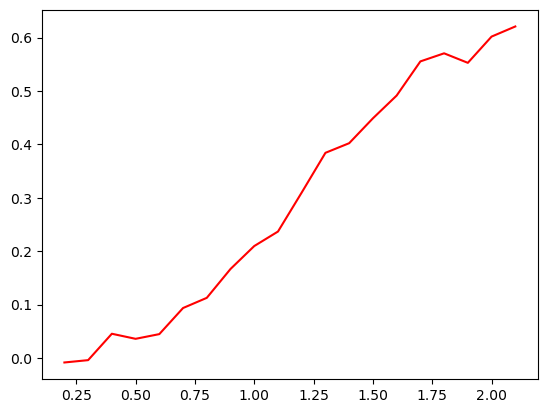

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
nobs_train = 20
train_data = datos[:nobs_train]
test_data = datos[nobs_train:]    
plt.plot(train_data['t'],train_data['yn'],color = 'red')

**Paso 3:** Ajustar un modelo a los datos de entrenamiento

In [9]:
# Crear matrices de diseño para los conjuntos de entrenamiento y prueba
exog_train = sm.add_constant(train_data[['y_1','y_2','u_1']])
exog_test = sm.add_constant(test_data[['y_1','y_2','u_1']])

# Ajustar el modelo 
model = sm.OLS(train_data['yn'], exog_train).fit()

# Imprimir un resumen del modelo
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     yn   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     559.4
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           3.08e-16
Time:                        14:38:26   Log-Likelihood:                 43.927
No. Observations:                  20   AIC:                            -81.85
Df Residuals:                      17   BIC:                            -78.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_1            1.0926      0.243      4.487      0.000       0.579       1.606
y_2           -0.0804      0.252     -0.319      0.753      -0.612       0.451
u_1            0.0126      0.006      2.197      0.042       0.000       0.025
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.047
Skew:                          -0.185   Prob(JB):                        0.592
Kurtosis:                       1.942   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.0017839294015925932


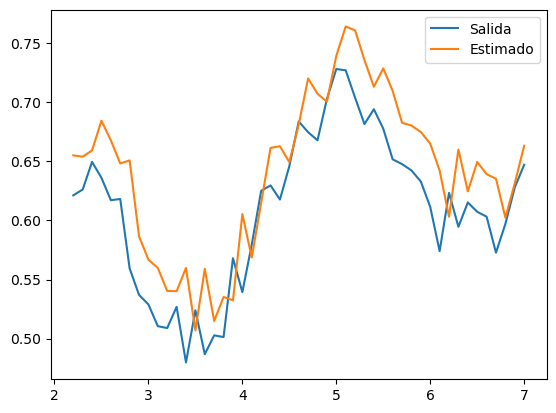

In [12]:
# Hacer predicciones en el conjunto de prueba
preds = model.predict(exog_test)

# Calcular el error cuadrático medio de las predicciones
mse = np.mean((preds - test_data['yn']) ** 2)

plt.plot(test_data['t'],test_data['yn'])
plt.plot(test_data['t'],preds)
plt.legend(['Salida','Estimado'])
print(mse)

In [11]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 - model.params.y_1*z**-1 - model.params.y_2*z**-2
B =  model.params.u_1*z**-1
## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

0.0125569281847963*z/(z**2 - 1.09256856148989*z + 0.0804275388779276)

array([[list([<matplotlib.lines.Line2D object at 0x000002781740EB90>]),
        list([<matplotlib.lines.Line2D object at 0x000002781740EE60>]),
        list([<matplotlib.lines.Line2D object at 0x000002781740F130>, <matplotlib.lines.Line2D object at 0x000002781740F3D0>])]],
      dtype=object)

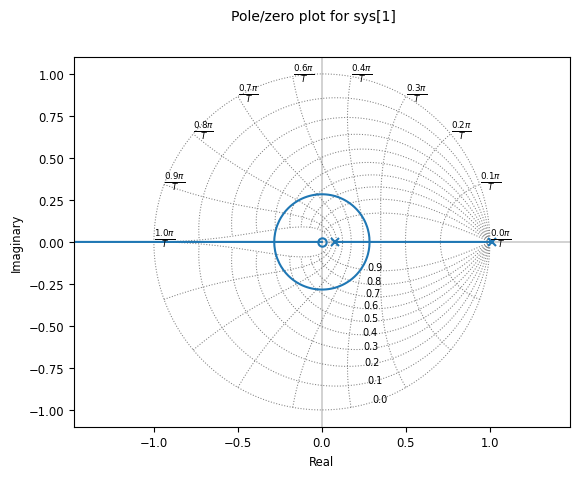

In [23]:
## Función de transferencia
G_e = control.tf([model.params.u_1,0],[1,-model.params.y_1,-model.params.y_2],dt)
control.rlocus(G_e)

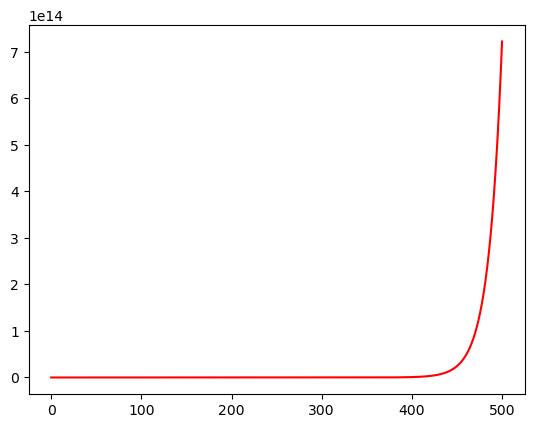

In [30]:
## Se determina la respuesta estimada al escalón
te,ye = control.step_response(G_e)
plt.plot(te,ye,color = 'red')
